<a href="https://colab.research.google.com/github/smolinad/quantum_machine_learning/blob/main/QSVM_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Machine learning Project:** QSVC implementation
**Sergio Quiroga Sandoval \
squirogas@unal.edu.co \
Universidad Nacional de Colombia**







This project is completely based on this reference paper: Supervised learning with quantum enhanced feature spaces.


The notebook has two objectives:

1. Reproduce the implementations of the paper. (modified version of Quiskit documentation: https://qiskit.org/ecosystem/machine-learning/tutorials/03_quantum_kernel.html#). Using the AD-HOC dataset.

2. Test the zz feature map in the same algorithm with its three types using the generated dataset **Moons** from scikit-learn.
The objective is to check its accuracy on a new scenario (this dataset).



The following are fundamental concepts that can be found in the paper and the following qiskit classes:
[From variational Classifiers to linear classifiers](https://www.youtube.com/watch?v=m6EzmYsEOiI)
[Quantum Feature Spaces and Kernels](https://www.youtube.com/watch?v=zw3JYUrS-v8)

*   Kernel, kernel matrix.
*   Quantum kernel.  
*   ZZ feature map.
*   Precomputed kernel matrix.



###Reproducibility

In [1]:
!pip install qiskit_machine_learning
!pip install qiskit-algorithms
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.9 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512576 sha256=c6ba7cd58029a838920d7ef0088fb7a8ad3748f113f684253f7

### For importing and plotting the dataset

In [ ]:
#Import the dataset, define the dataset dimension and get our train and test subsets:



from qiskit_machine_learning.datasets import ad_hoc_data

#Using the same qiskit seed for cheking results
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

#define the dataset dimension
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    #define  our train subset dimension
    training_size=20,
    #Define test subset dimension
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)


#code for plotting the chosen dataset


import matplotlib.pyplot as plt
import numpy as np

# A train plot
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    ax.scatter(
        # x coordinate of labels where class is class_label
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


# a function for plotting the dataset points

def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):
  # defining plot size
    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()


    # libraries for QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

<ipython-input-18-79bb5caf5422>:4: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 12345


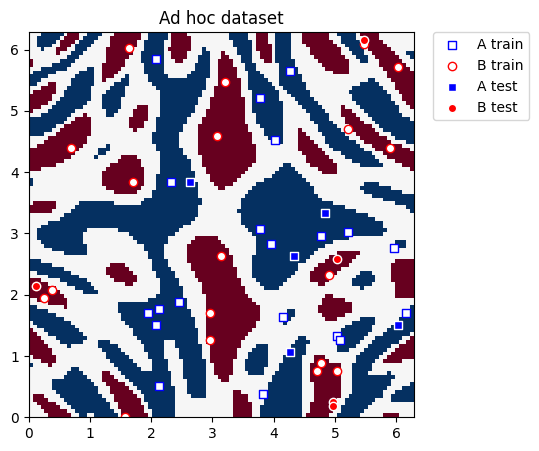

In [ ]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)


#Quantum Support Vector Classifier
Some important concepts:\
**Feature map**: Data cannot typically be separated by a hyperplane in its original space. A common technique used to find such a hyperplane consists of applying a non-linear transformation function to the data. This function is called a , as it transforms the raw features, or measurable properties, of the phenomenon or subject under study.

**Classifying**  in this new feature space and, also in any other space, including the raw original one- is nothing more than seeing **how close data points are** to each other. This is the same as computing the inner product for each pair of data points in the set. So, in fact we do not need to compute the non-linear feature map for each datum, but only the inner product of each pair of data points in the new feature space.

 **Quantum kernel**:   The collection of inner products is called the kernel and it is perfectly possible to have feature maps that are hard to compute but whose kernels are not." - Qiskit

In [ ]:
#create a quantum kernel instance that will help classify the data.
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

# in this case the feature map is a two-qubit ZZFeatureMap.
sampler = Sampler()

 #the ComputeUncompute fidelity subroutine leverages the Sampler primitive.
fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

The quantum kernel can now be plugged into classical kernel methods

In [ ]:
#QSVC is an alternative training algorithm provided by qiskit-machine-learning
from qiskit_machine_learning.algorithms import QSVC


#QSVC is an extension of SVC that takes in a quantum kernel instead of the kernel.evaluate
qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


### SVC using kernel as a callable function

adhoc_kernel.evaluate

In [ ]:
from sklearn.svm import SVC

# Directly pass the evaluate function of the quantum kernel as a callable.
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

 # Train the SVC by calling the fit method
adhoc_svc.fit(train_features, train_labels)

# Evaluate the model for accuracy
adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


### SVC using Precomputed Kernel matrix

"Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the scikit-learn SVC algorithm."

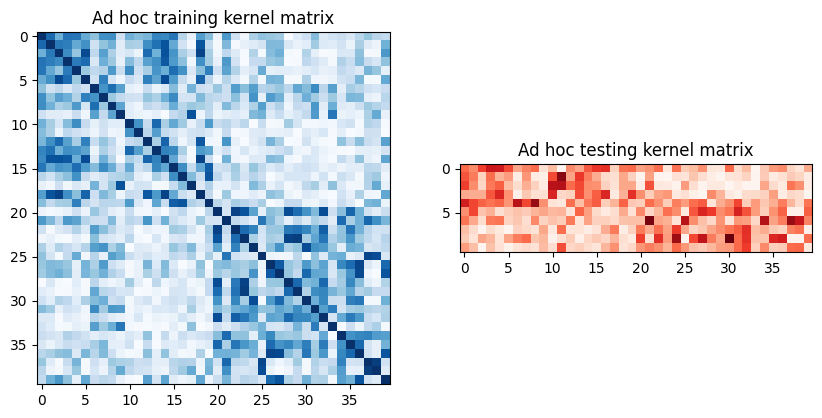

In [ ]:
# We Precompute training and testing kernel matrices before passing them to the scikit-learn SVC algorithm.

#extract the train and test matrices
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)


#then we generate the plots for visualizing the matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

"To use these matrices, we set the kernel parameter of a new SVC instance to "precomputed". We train the classifier by calling fit with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset."

In [ ]:
#We train a new SVC
# We use these generated matrices by setting the kernel parameter instance to "precomputed"
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

# Evaluate the accuracy of this classifier with score function
adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)
print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


### Evaluation of the three models

In [ ]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00


This code is a part of Qiskit
© Copyright IBM 2017, 2023.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.

(this code has been altered)


They conjecture by the results on the generated data that the ZZ feature map can be a suitable feature map for achieving a quantum advantage.

# QSVC for Moons dataset

This is new code

In [ ]:
from sklearn.datasets import make_moons
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import time
import numpy as np
import pylab as pl
#--------------------------------------------------
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
import qiskit_algorithms
from qiskit_machine_learning.kernels import FidelityQuantumKernel

from qiskit.algorithms.state_fidelities import ComputeUncompute

from qiskit import QuantumCircuit, Aer, execute
#---------------------------------QSVC
from qiskit_machine_learning.algorithms import QSVC


In [ ]:

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 10)
    y_vals = np.linspace(min_y, max_y, 10)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.reshape(X_grid_preds_total, (grid_r, grid_c))
    #print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.125*i for i in range(1,8)])
    #CS = pl.contour(XX, YY, ZZ, 100, levels = [0.5])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

##QSVM in qiskit for Mooons

In [ ]:
!git clone https://github.com/SergioQS/Datasets

In [ ]:
# upload features from the cloned github page

X_train = np.load("/content/Datasets/MoonsQMC_gamma32_4classqaff_mixed_average_Xtrain_190923.npy")
X_test = np.load("/content/Datasets/MoonsQMC_gamma32_4classqaff_mixed_average_Xtest_190923.npy")
X_grid = np.load("/content/Datasets/MoonsQMC_gamma32_4classqaff_mixed_average_Xgrid_190923.npy").reshape((20, 20, 2))[::2, ::2, :].reshape(100, 2)
X_feat_train = np.load("/content/Datasets/MoonsQMC_gamma32_4classqaff_mixed_average_X_qaff_train_190923.npy")
X_feat_test = np.load("/content/Datasets/MoonsQMC_gamma32_4classqaff_mixed_average_X_qaff_test_190923.npy")
X_feat_grid = np.load("/content/Datasets/MoonsQMC_gamma32_4classqaff_mixed_average_X_qaff_grid_190923.npy").reshape((20, 20, 4))[::2, ::2, :].reshape(100, 4)

## upload targets and predictions

y_train = np.load("/content/Datasets/MoonsQMC_gamma32_4classqaff_mixed_average_Ytrain_190923.npy")
y_test = np.load("/content/Datasets/MoonsQMC_gamma32_4classqaff_mixed_average_Ytest_190923.npy")

X_train.shape, X_test.shape, X_grid.shape, X_feat_train.shape, X_feat_test.shape, X_feat_grid.shape, y_train.shape, y_test.shape

((900, 2),
 (100, 2),
 (100, 2),
 (900, 4),
 (100, 4),
 (100, 4),
 (900, 1),
 (100, 1))

Now we are going to implement the QSVC with the loaded data from the Moons dataset, using the same feature map (ZZ feature map).

In [ ]:

#Creating a quantum kernel instance that will help classify the data.
 # in this case the feature map is a two-qubit ZZFeatureMap.
adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

#use the FidelityQuantumKernel class, and pass two input arguments fidelity and feature_map
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)


In [ ]:
#QSVC is an extension of SVC that takes in a quantum kernel instead of the kernel.evaluate
qsvc = QSVC(quantum_kernel=adhoc_kernel)

# fitting and testing QSVC with the defined kernel from previous block
qsvc.fit(X_train, y_train)

#testing
qsvc_score = qsvc.score(X_test, y_test)


## Manipulating data for plotting (one-hot encodings)

In [ ]:
### one-hot encode the labels for the plotting function defined before in the notebook

y_train_oh = np.zeros((len(y_train), 2))
for i in range(len(y_train)):
  if y_train[i] == 0:
    y_train_oh[i, 0] = 1
  else:
    y_train_oh[i, 1] = 1

len(y_train_oh)

900

In [ ]:
X_test_preds = qsvc.predict(X_test)

In [ ]:
# one-hot encode the predicts for X_test
X_test_preds_oh = np.zeros((len(X_test_preds), 2))
for i in range(len(X_test_preds)):
  if X_test_preds[i] == 0:
    X_test_preds_oh[i, 0] = 1
  else:
    X_test_preds_oh[i, 1] = 1

len(X_test_preds_oh)

X_test_preds_zero = X_test_preds_oh[:,0]
X_test_preds_one = X_test_preds_oh[:,1]
X_grid_preds = qsvc.predict(X_grid)

# one-hot encode the predicts for X_grid
X_grid_preds_oh = np.zeros((len(X_grid_preds), 2))
for i in range(len(X_grid_preds)):
  if X_grid_preds[i] == 0:
    X_grid_preds_oh[i, 0] = 1
  else:
    X_grid_preds_oh[i, 1] = 1

len(X_grid_preds_oh)

# extract the predictions for X_test and X_grid data sets

X_grid_preds_zero = X_grid_preds_oh[:,0]
X_grid_preds_one = X_grid_preds_oh[:,1]

In [ ]:
# Classical adaptation of data test data
prior_zero = (len(y_train) - y_train.sum()) / len(y_train)
prior_one = y_train.sum() / len(y_train)
X_test_preds_zero, X_test_preds_one = prior_zero * np.array(X_test_preds_zero), prior_one * np.array(X_test_preds_one)
X_test_preds_total =  X_test_preds_one / ( X_test_preds_zero + X_test_preds_one)

# Classical adaptation of data grid data
prior_zero = (len(y_train) - y_train.sum()) / len(y_train)
prior_one = y_train.sum() / len(y_train)
X_grid_preds_zero, X_grid_preds_one = prior_zero * np.array(X_grid_preds_zero), prior_one * np.array(X_grid_preds_one)
X_grid_preds_total =  X_grid_preds_one / ( X_grid_preds_zero + X_grid_preds_one)

X_test_preds_total.shape, X_grid_preds_total.shape

((100,), (100,))

## Some testing results with different data samples:


*   Con 50 samples: 0.8 test score
*   Con 200 samples: 0.9 test score  (1min30s)
*   con 1000 samples: 0.92 (50 mins)

The final results are in the last block of the notebook.



<ipython-input-27-1df29db440d4>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


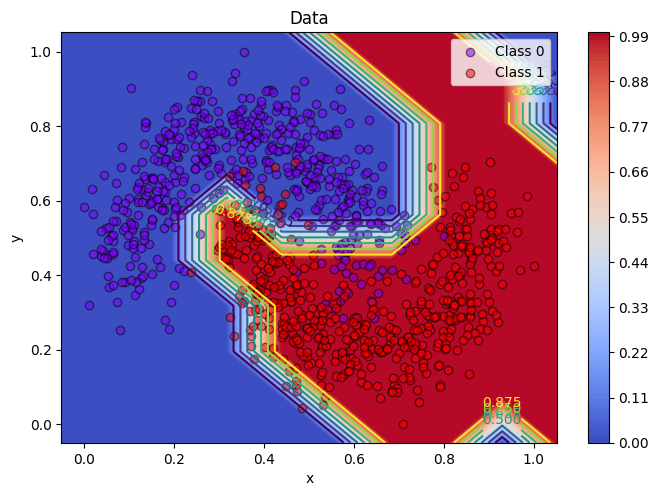

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(np.concatenate([X_train, X_test]))
plot_data(np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test]).ravel())

# SVC using callable function for Moons dataset

In [ ]:
from sklearn.svm import SVC

# Directly pass the evaluate function of the quantum kernel as a callable.
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

 # Train the SVC by calling the fit method
adhoc_svc.fit(X_train, y_train)

# Evaluate the model accuracy
adhoc_score_callable_function = adhoc_svc.score(X_test, y_test)

# SVC using precomputed kernel matrix for moons dataset

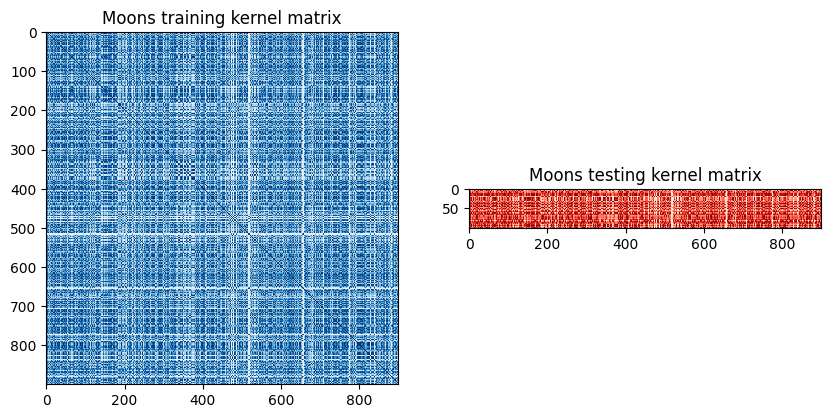

In [ ]:
# We Precompute training and testing kernel matrices before passing them to the scikit-learn SVC algorithm.

#extract the train and test matrices
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=X_train)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=X_test, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


#then we generate  plots for visualizing the matrices

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Moons training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Moons testing kernel matrix")

plt.show()

In [ ]:
# We use these generated matrices by setting the kernel parameter instance to "precomputed"
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, y_train)

# Evaluate the accuracy of this classifier with score
adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, y_test)

# Results

In [ ]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       0.92
SVC using precomputed kernel matrix     |       0.92
QSVC                                    |       0.92


# Conclusions
We provide a new implementation of the methods proposed by Havlick. et al in “Supervised learning with quantum-enhanced feature spaces".

This new implementation is done using the Moons dataset, the used dataset data can be found in https://github.com/smolinad/quantum_machine_learning/datasets.
We get a 92% accuracy score for this new dataset, this is a good performance and it is important for showing one example when the zz-feature map can achieve results in a different dataset than the ad-hoc generated in the paper of Havlick et al.

Thank you for reading!